In [1]:
from scilab import *
%matplotlib inline

In [2]:
wid,hig=70,70
ini_dens = 0.3

In [3]:
def isLiving(state, neighbers):
    if state==True:
        if neighbers<2:
            return False
        elif neighbers>3:
            return False
    else:
        if neighbers==3:
            return True
    return state

In [4]:
cells=np.random.rand(hig,wid)
cells=cells < ini_dens
cells=cells.astype(int)

In [5]:
def count_neighbers(row,clu):
    l,r,u,b=clu-1,clu+2,row-1,row+2
    l = l if l>=0 else 0
    u = u if u>=0 else 0
    nei=cells[u:b,l:r]
    return nei.sum()-cells[row,clu]

In [6]:
count_neighbers(0,8)

1

In [7]:
def run():
    global cells
    cells_new=cells.copy()
    for r,c in ((r,c) for r in range(hig) for c in range(wid)):
        if isLiving(cells[r,c], count_neighbers(r,c)):
            cells_new[r,c]=1
        else:
            cells_new[r,c]=0
    
    cells=cells_new

In [8]:
run()
cells

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

1457 10


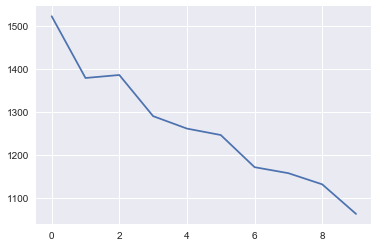

In [9]:
cells = np.random.rand(hig,wid)
cells = cells < ini_dens
cells = cells.astype(int)
ini = cells.sum()
re=[]
cells_last=0
for i in range(10):
    cells_last=cells
    run()
    re.append(cells.sum())
    if (cells_last==cells).all():
        break
print(ini,len(re))
plot(re)

In [10]:
len(re)

10

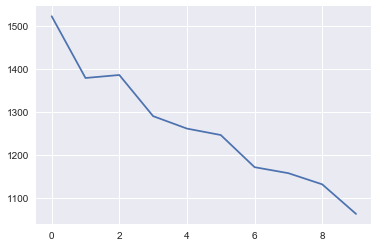

In [11]:
plot(re)

## rule30

In [12]:
from scilab import *
%matplotlib inline

In [13]:
class ruleN:
    def __init__(self, iniLine=None, aliveCon=[1,2,3,4], NumGeneration=50, length=None):
        self.aliveCon = aliveCon
        self.NumGeneration = NumGeneration
        length = length or NumGeneration*2 - 1
        if iniLine == None:
            iniLine = np.zeros(length, dtype=int)
            iniLine[int((length+1)/2)]=1
        else:
            iniLine = array(iniLine)
            iniLine = iniLine.astype(bool).astype(int)
        self.result = [iniLine]
        self.length = len(iniLine)
        
    def shift(a,n,fill=0):
        a = np.roll(a, n)
        if n>0:
            a[:n]=fill
        else:
            a[n:]=fill
        return a
    
    def liveCode(a):
        s = ruleN.shift
        return s(a,-1) + 2*a + 4*s(a,1)
    
    def nextGeneration(self):
        n =  ruleN.liveCode(self.result[-1])
        return np.isin(n, self.aliveCon).astype(int)
    
    def iterition(self):
        while len(self.result) < self.NumGeneration:
            n = self.nextGeneration()
            self.result.append(n)
    def show(self):
        with sb.axes_style("white"):
            plt.imshow(self.result)
        plt.show()

In [14]:
r=ruleN()

In [15]:
r.iterition()

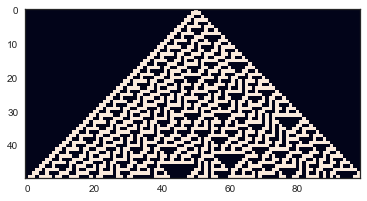

In [16]:
r.show()

## game of life

In [3]:
from scilab import *
%matplotlib inline

from PIL import Image

In [4]:
from partitEquivalence import partitEquivalence

In [5]:
class lifegame:
    
    def __init__(self, wordSize=(10,10), ini_dens=0.3, survivalWin=(2,3),
                 maxGeneration=1000, partrol_len=(10,20,40), boundaryType="circle"):
        """
        maxGeneration、partrol_len用于控制自动迭代，
        maxGeneration 是循环的最大代数，
        partrol_len 是检测循环节的每个巡逻兵巡逻的区间长度。sum(partrol_len)是能检测到的最长循环节
        boundaryType 边界类型，取值"circle","zeropadding"
        """
        self.height, self.width = self.wordSize = wordSize
        self.ini_dens = ini_dens
        self.survivalWin = survivalWin
        cells = np.random.rand(self.height, self.width)
        cells = cells < ini_dens
        self.cells = cells.astype(int)
        self.result = [self.cells.copy()]
        self.maxGeneration = maxGeneration
        self.patrol = [0] * len(partrol_len)
        self.partrol_len = partrol_len
        self.patrol_end = array(partrol_len).cumsum()
        self.patrol_beg = array((1,)+partrol_len[:-1]).cumsum()
        self.period = None
        shift_dict = {"circle":lifegame.shift_circle,
                   "zeropadding":lifegame.shift_zeropadding}
        self.shift = shift_dict[boundaryType]
        
    def shift_circle(arr, disp_pairs):
        shift = lambda d,r: np.roll(arr,(d,r),axis=(0,1)) 
        #down-toeards, right-towards
        
        return [shift(d,r) for d,r in disp_pairs]
    
    def shift_zeropadding(arr, disp_pairs):
        h,w = arr.shape
        paded = np.zeros((h+2,w+2), dtype=int)
        paded[1:-1,1:-1] = arr
        
        shift = lambda d,r: paded[-d+1:-d+1+h, -r+1:-r+1+w]
        return [shift(d,r) for d,r in disp_pairs]
    
    def count_neighbers(self):
        neighbers = [(1,1),(1,0),(1,-1),(0,1),(0,-1),(-1,1),(-1,0),(-1,-1)]
        
        return sum(self.shift(self.cells, neighbers))
    
    def nextGeneration(self):
        l,h = self.survivalWin #too low, too high
        m = int((h+l)/2+0.5) #just fine
        nc = self.count_neighbers()
        self.cells[nc<l] = 0
        self.cells[nc>h] = 0
        self.cells[nc==m] = 1
        self.result.append(self.cells.copy())
        return self.cells
   
    def saveGIF(self, fn, duration=250, re=None):
        re = re or self.result
        saveGIF(fn, re, duration)
        
    def checkRepetend(self):
        "检测循环节"
        current_i = len(self.result) - 1
        for i in range(len(self.patrol)):
            p = self.patrol[i]
            if current_i - p > self.patrol_end[i]:
                self.patrol[i] = p = current_i - self.patrol_beg[i]
            if current_i - p < self.patrol_beg[i]:
                pass
            else:
                if np.array_equal(self.result[p],self.result[-1]):
                    self.period = current_i - p
                    return True
                
    def iterition(self, n_iter=None):
        n_iter = n_iter or self.maxGeneration
        self.patrol = [len(self.result) - 1 for _ in self.patrol]
        for i in range(n_iter):
            self.nextGeneration()
            
            if self.checkRepetend():
                print("Stopped after %s iterations. Found period = %s"%(i+1,self.period))
                break
              
    def plotPopulation(self):
        "绘制人口曲线"
        plot([a.sum() for a in self.result])
        plt.show()
        
    def static_analyse(self, ind):
        im = l.result[ind]
        idim = to_id_image(im)
        
        neipairs = neiPairsOf(idim, shift=self.shift)
        points = np.unique(idim[idim!=-1])
        
        groups = partitEquivalence(neipairs, points).equivalence
        return groups
    
    def plotGroup(self, imind, group):
        plotGroup(self.result[imind], group)

In [6]:
toImage = lambda arr: Image.fromarray(0xff-arr.astype(np.uint8)*0xff, mode="L")
def saveGIF(fn, re, duration=250):
    imlist = [toImage(r) for r in re[1:]]
    toImage(re[0]).save(fn, save_all=True, append_images=imlist, duration=duration,
                        optimize=True, minimize_size=True)

In [40]:
def neiPairsOf(idim, trans=-1, shift=None):

    shift = shift or (lambda im,pairs:[np.roll(im,(d,r),axis=(0,1)) for d,r in pairs])
    
    def toNeiPairs(a, b):
        a = a.reshape(-1, 1)
        b = b.reshape(-1, 1)
        pairs = np.hstack([a,b])
        pairs = pairs[pairs[:,0] != trans]
        pairs = pairs[pairs[:,1] != trans]
        return pairs
    
    neiPairs = [toNeiPairs(idim, neimage) for neimage in shift(idim, [(1,0),(0,1),(1,1),(1,-1)])]
        
    return np.vstack(neiPairs)

def to_id_image(im, transOld=0, transNew=-1):
    idim = np.arange(im.ravel().shape[0]).reshape(im.shape)
    idim[im==transOld] = transNew
    return idim

def toCoords(ids, shape):
    ids = array(ids)
    m,n = shape
    r = ids // n
    c = ids % n
    return np.column_stack([r,c])

def plotGroup(im, group):
    plt.imshow(im)
    
    yx = toCoords(list(group), im.shape)
    plot(yx[:,1],yx[:,0],'r.')
    plt.show()

In [8]:
def delta(axis, neisum):
#     neisum[im==0] = 0
    neisNum = neisum.sum(axis=(1,0)[axis])
    mask = neisNum == neisNum.min()
    print(mask)
    mininds = np.arange(len(mask))[mask]
    print(mininds)
    indpairs = np.zeros((len(mininds),2), dtype=int)
    indpairs[:, axis] = mininds
    shiftdis = -1-neisNum.argmin()
    d = np.zeros(2, dtype=int)
    d[axis] = shiftdis
    return indpairs#d

In [9]:
delta(1,array([[5,4,1,6,7,1,8]]*2))

[False False  True False False  True False]
[2 5]


array([[0, 2],
       [0, 5]])

In [10]:
def replacement(im, axis, shift=None):
    """
    将图片重新置放
    规则，循环（maybe，取决于shift函数）移动图片，使边界落在在邻胞最少处
    axis: 取值0,1或（0,1）
    """
    shift = shift or (lambda im,pairs:[np.roll(im,(d,r),axis=(0,1)) for d,r in pairs])
    
    neisDict = {0:[(-1,-1),(-1,0),(-1,1)], 1:[(-1,-1),(0,-1),(1,-1)],
                (0,1):[(-1,-1),(-1,0),(-1,1),(0,-1),(1,-1)]}
    
    neis = neisDict[axis]
    neis = shift(im, neis)

    def delta(axis, neis):
        neissum = sum(neis)
        neissum[im==0] = 0
        neisNum = neissum.sum(axis=(1,0)[axis])
        minind = neisNum.argmin()
        d = np.array([0,0])
        d[axis] = -1 - minind            
        return d
    
    
    if axis == 0 or axis == 1:
        d = delta(axis, neis)
    elif axis == (0,1):
        d = delta(0, neis[:3]) + delta(1, neis[3:])
    
    return d

In [11]:
def coToIm(c):
    ul = c.min(axis=0)
    lr = c.max(axis=0)
    shape = lr - ul
    c = c - ul

    im = np.zeros(shape+1)
    im[(*c.T,)] = 1
    return im

def imageOf(coords, border, shift=None):
    ymin, xmin = coords.min(axis=0)
    ymax, xmax = coords.max(axis=0)
    
    axisCode = 0
    if xmin == 0 and xmax == border[1]-1:
        axisCode += 1
    if ymin == 0 and ymax == border[0]-1:
        axisCode += 2
    if axisCode:
        im = coToIm(coords)
        d = replacement(im, {1:1,2:0,3:(0,1)}[axisCode])
        
        coords = coords + d
        coords[coords[:,0]<0, 0] += border[0]
        coords[coords[:,1]<0, 1] += border[1]

    return coToIm(coords)

* survivalWin=(2,3),ini_dens=0.3  标准  
* survivalWin=(0,2),ini_dens=0.01 闪烁  
* survivalWin=(0,1),ini_dens=0.01 随机无尽  
10000循环节捕获失败,wordSize=(15,15)  更正:其实是很难冷却，after gen=158495,有period=4，此时往往是随机到了细胞数过少的情况（已灭绝或简单模式），若人为补充细胞仍能回到系统性的无尽随机中；当wordSize足够大，细胞过少情况不易发生。  
* survivalWin=(1,3),ini_dens=0.01 细胞生长, also survivalWin=(0,3).

In [49]:
l = lifegame(wordSize=(50,100), survivalWin=(1,3),ini_dens=0.4,boundaryType="circle",
             partrol_len=(10,20,40))

In [50]:
l.iterition()

Stopped after 36 iterations. Found period = 6


In [51]:
if not l.period:
    l.iterition(20000)
"%s frames, period=%s, %s cells left."%(len(l.result),l.period,l.result[-1].sum())

'37 frames, period=6, 2193 cells left.'

128 groups
group_1 has max size 329


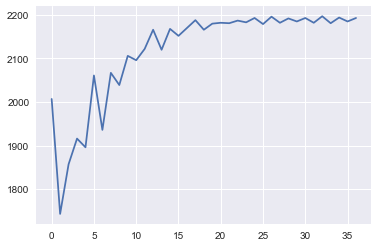

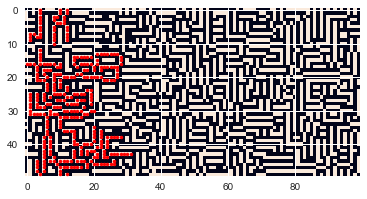

In [52]:
ind = -1
groups = l.static_analyse(ind)
print(len(groups),"groups")
groupsize = [len(g) for g in groups]
maxgroup = max(enumerate(groupsize), key=lambda x:x[-1])
print("group_%s has max size %s"%maxgroup)

l.plotPopulation()
# plt.subplot(121)
# plt.imshow(l.result[-1])
# plt.subplot(122)
l.plotGroup(ind, groups[maxgroup[0]])

(49, 32)

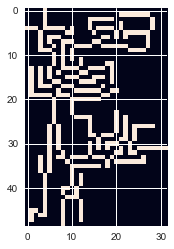

In [53]:
coords = toCoords(list(groups[maxgroup[0]]), l.wordSize)
gim = imageOf(coords, l.wordSize, shift=l.shift)
plt.imshow(gim)
gim.shape

In [48]:
fn = "%s_%s_%s_w%s%s.gif"%(len(l.result),l.period,l.result[-1].sum(),*l.survivalWin)
l.saveGIF(fn)
fn

'33_2_389_w13.gif'

In [26]:
for i,r in enumerate(l.result):
    pass#plt.imsave(fname=r"D:\livegame\%s.png"%i,arr = r)

In [27]:
saveGIF("rrrr.gif",l.result[-1000:],duration=200)

In [28]:
plt.imsave(fname=r"result-1.png",arr = l.result[-1])